In [1]:
import os
import platform
import random
import time
import sys

import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import tensorflow as tf
from IPython.display import HTML
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import models, layers
from tensorflow.keras.utils import Progbar

# silence tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# getting rid of the warning messages about optimizer graph
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)

2023-04-20 16:51:33.242358: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-20 16:51:33.331367: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-20 16:51:33.779001: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-20 16:51:33.779065: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [2]:
# print Tensorflow and CUDA information
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
 
if tf.test.gpu_device_name():
    gpu_devices = tf.config.list_physical_devices('GPU')
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    name = details.get('device_name', 'Unknown GPU')
    
    print(f"Using {name}")
else:
    print("No GPU found")

Num GPUs Available:  1
Num CPUs Available:  1
Tensorflow version: 2.11.0
Keras version: 2.11.0
Using NVIDIA GeForce RTX 3070 Laptop GPU


2023-04-20 16:51:34.507009: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-20 16:51:34.522022: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-20 16:51:34.522056: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-20 16:51:34.524605: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-20 16:51:34.524634: I tensorflow/compile

In [3]:
# Seed control, for better reproducibility 
# NOTE: this does not gurantee results are always the same
seed = 22
random.seed(seed)
np.random.seed(seed)

BATCH_SIZE = 512 # might try to use large batches (we will discuss why later when we talk about BigGAN)
# NOTE: the batch_size should be an integer divisor of the data set size  or torch
# will give you an error regarding batch sizes of "0" when the data loader tries to
# load in the final batch

# setup GAN dataset
(train_images_raw, train_labels_raw), (_, _) = tf.keras.datasets.cifar10.load_data()

# only use airplane, automobile, ship, and truck images
# train_images_raw = train_images_raw[np.where(np.isin(train_labels_raw, [0, 1, 8, 9]))[0]]
# train_labels = train_labels_raw[np.where(np.isin(train_labels_raw, [0, 1, 8, 9]))[0]]

# only use airplane and ship images
train_images_raw = train_images_raw[np.where(np.isin(train_labels_raw, [0, 8]))[0]]
train_labels = train_labels_raw[np.where(np.isin(train_labels_raw, [0, 8]))[0]]

# Re-encode the labels to be in the range [0, num_classes)
unique_labels = np.unique(train_labels)
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
train_labels = np.array([label_mapping[label] for label in train_labels.flatten()]).reshape(-1, 1)

train_images = train_images_raw.reshape(train_images_raw.shape[0], 32, 32, 3).astype('float32')
# Normalize the images to [-1, 1]
train_images = (train_images - 127.5) / 127.5

num_classes = len(np.unique(train_labels))

# print the shape of the dataset
print(f"Shape of the dataset: {train_images.shape}")

# print the number of images in each class
print(f"Number of images in each class: {np.unique(train_labels, return_counts=True)[1]}")

# set the buffer size to the size of the dataset
BUFFER_SIZE = train_images.shape[0]

train_dataset_images = tf.data.Dataset.from_tensor_slices(train_images)
train_dataset_labels = tf.data.Dataset.from_tensor_slices(train_labels)

train_dataset = tf.data.Dataset.zip((train_dataset_images, train_dataset_labels))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Shape of the dataset: (10000, 32, 32, 3)
Number of images in each class: [5000 5000]


2023-04-20 16:51:35.339865: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-20 16:51:35.339937: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-20 16:51:35.339953: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-20 16:51:35.340279: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-20 16:51:35.340289: I tensorflow/core/co

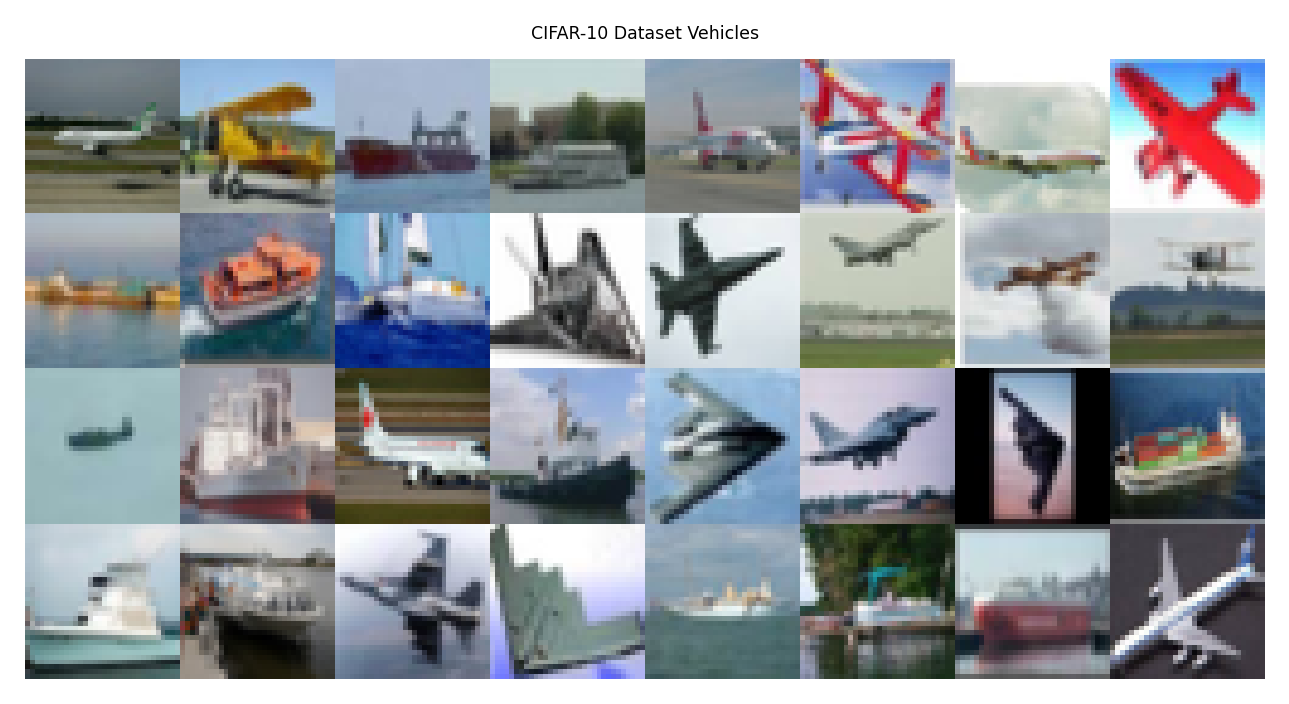

In [4]:
def make_grid(images):
    num_images = 32
    height = 4
    width = num_images // height

    size = images.shape[1]
    grid = np.zeros((height * size, width * size, 3))

    # Get the total number of images in img_batches
    total_images = images.shape[0]

    # if the number of images is less than the number of images we want to display
    # then we will just display all the images
    if total_images < num_images:
        num_images = total_images

    for i in range(height):
        for j in range(width):
            idx = i * width + j

            if idx >= num_images:
                break

            # Get the image from the batch
            im = images[idx, :, :, :]

            # Reshape the image into a square
            im = im.reshape((size, size, 3))

            # Add the image to the grid
            grid[i * size:(i + 1) * size, j * size:(j + 1) * size, :] = im

    # Normalize the grid values to the range [0, 1] for displaying
    grid = (grid - grid.min()) / (grid.max() - grid.min())

    return grid

def plot_grid(grid, title=None):

    # Create a figure with double the DPI
    plt.figure(dpi=2.5 * plt.rcParams['figure.dpi'])

    if title is not None:
        plt.title(title, fontsize=5)
        
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

grid = make_grid(train_dataset.take(1).as_numpy_iterator().next()[0])
plot_grid(grid, title="CIFAR-10 Dataset Vehicles")

In [5]:
latent_dim = 128
size = 32
channels = 3
num_classes = len(np.unique(train_labels))
print(f"Number of classes: {num_classes}")

generator_in_channels = latent_dim + num_classes
discriminator_in_channels = channels + num_classes
print(generator_in_channels, discriminator_in_channels)


# this model originally from https://www.tensorflow.org/tutorials/generative/dcgan 
# manipulated to have different sizing possible
def make_generator_model():
    noise_input = layers.Input(shape=(latent_dim,))
    label_input = layers.Input(shape=(1,), dtype='int32')
    
    # Embed the label input and reshape it
    label_embedding = layers.Embedding(num_classes, latent_dim)(label_input)
    label_embedding = layers.Reshape((latent_dim,))(label_embedding)
    
    # Concatenate the noise input and label embedding
    combined_input = layers.Concatenate()([noise_input, label_embedding])
    
    int_size_4 = int(size/4)
    x = layers.Dense(int_size_4 * int_size_4 * 256, use_bias=False)(combined_input)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Reshape((int_size_4, int_size_4, 256))(x)

    x = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.UpSampling2D(size=(2, 2), interpolation='nearest')(x)
    x = layers.Conv2D(64, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.UpSampling2D(size=(2, 2), interpolation='nearest')(x)
    x = layers.Conv2D(channels, (3, 3), padding='same', use_bias=False, activation='tanh')(x)

    model = tf.keras.Model(inputs=[noise_input, label_input], outputs=x)
    
    return model


Number of classes: 2
130 5


In [6]:
def make_discriminator_model():
    image_input = layers.Input(shape=(size, size, channels))
    label_input = layers.Input(shape=(1,), dtype='int32')
    
    # Embed the label input and reshape it
    label_embedding = layers.Embedding(num_classes, size * size)(label_input)
    label_embedding = layers.Reshape((size, size, 1))(label_embedding)
    
    # Concatenate the image input and label embedding along the channel axis
    combined_input = layers.Concatenate(axis=-1)([image_input, label_embedding])
    
    x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(combined_input)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(1)(x)
    
    model = tf.keras.Model(inputs=[image_input, label_input], outputs=x)
    
    return model


2023-04-20 16:51:36.862325: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-04-20 16:51:37.504250: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204


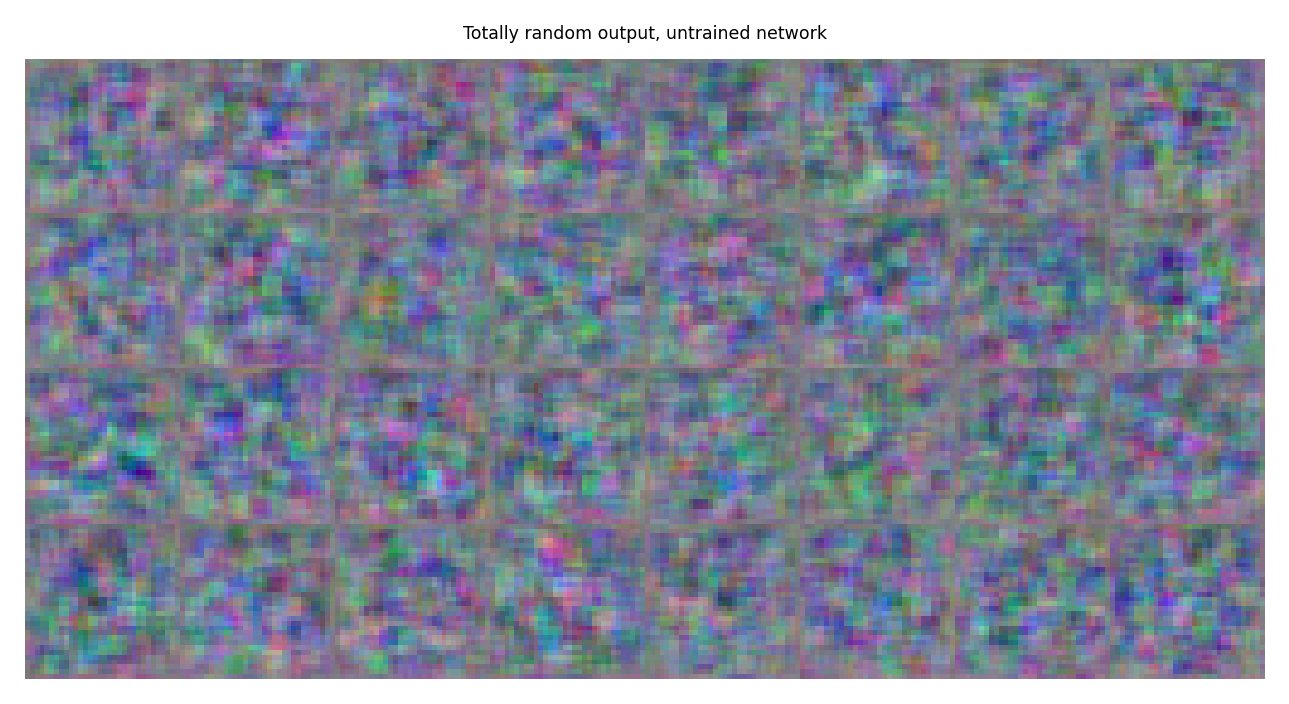

(512, 1)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 128)       256         ['input_2[0][0]']                
                                                                                                  
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 reshape (Reshape)              (None, 128)          0           ['embedding[0][0]']              
                                                                                     

In [7]:
# Initialize generator and discriminator
generator = make_generator_model()
discriminator = make_discriminator_model()

noise = tf.random.normal([BATCH_SIZE, latent_dim])
random_labels = tf.random.uniform(shape=(BATCH_SIZE, 1), minval=0, maxval=num_classes, dtype=tf.int32)
generated_image = generator([noise, random_labels], training=False)

random_grid = make_grid(generated_image.numpy())
plot_grid(random_grid, title='Totally random output, untrained network')

decision = discriminator([generated_image, random_labels], training=False)
print(decision.numpy().shape) # print out 256 decisions

generator.summary()

In [8]:
# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss # minimize (slides have max in them)


# Define the loss functions for the generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img) # minimize (slides have max in them)

#---------------------------
# params from WGAN-GP paper
#---------------------------
# number of training steps for discriminator per iter for WGANGP
n_critic = 3
# Loss weight for gradient penalty
lambda_gp = 10

generator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)

# create Utils functions for saving and loading 
checkpoint_dir = 'models/' 
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

num_examples_to_generate = 32 
# 8x8 grid of thr outputs, for testing over time

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
test_latent_dims = tf.random.normal([num_examples_to_generate, latent_dim])
test_labels = tf.random.uniform(shape=(num_examples_to_generate, 1), minval=0, maxval=num_classes, dtype=tf.int32)

# create Utils functions for saving and loading 
checkpoint_dir = 'models/tf_training_checkpoints/' 
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

def checkpoint_images(model, test_input, file_prefix):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    grid = make_grid(predictions.numpy())
    
    np.save(f'models/{file_prefix}_images.npy',grid)
    
    return grid

In [9]:
@tf.function # commenting this as there is some problem with non-eager...
def train_step_basic(images, labels):


    # Train the discriminator first. The original paper recommends training
    # the discriminator for `x` more steps (typically 5) as compared to
    # one step of the generator. Here we will train it for 3 extra steps
    # as compared to 5 to reduce the training time.
    batch_size = tf.shape(images)[0]

    for i in range(5):

        # Get the latent vector
        noise = tf.random.normal([batch_size, latent_dim])
        generated_labels = tf.random.uniform([batch_size, 1], minval=0, maxval=num_classes, dtype=tf.int32)

        with tf.GradientTape() as disc_tape:

            # Generate fake images from the latent vector
            generated_images = generator([noise, generated_labels], training=True)

            # also get interpolations for the gradient penalty
            alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
            diff = generated_images - images
            interpolated = images + alpha * diff

            # Get the logits for the fake images
            fake_output = discriminator([generated_images, generated_labels], training=True)

            # Get the logits for the real images
            real_output = discriminator([images, labels], training=True)

            # Calculate the discriminator loss using the fake and real image logits
            disc_loss = discriminator_loss(real_output,fake_output)

            # code from https://keras.io/examples/generative/wgan_gp/
            # Calculate the gradient penalty
            with tf.GradientTape(watch_accessed_variables=False) as gp_tape:
                gp_tape.watch(interpolated) # manually define what to watch
                # 1. Get the discriminator output for this interpolated image.
                pred = discriminator([interpolated, labels], training=True)

            # Calculate the gradients w.r.t to this interpolated image.
            grads = gp_tape.gradient(pred, [interpolated])[0]

            # Calculate the norm of the gradients.
            norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
            gp = tf.reduce_mean((norm - 1.0) ** 2) # is norm close to 1?

            # Add the gradient penalty to the original discriminator loss
            d_loss = disc_loss + gp * lambda_gp

        # Get the gradients w.r.t the discriminator loss
        gradients_of_discriminator = disc_tape.gradient(d_loss, discriminator.trainable_variables)

        # Update the weights of the discriminator using the discriminator optimizer
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))



    # Train the generator
    # Get the latent vector
    noise = tf.random.normal([batch_size, latent_dim])
    labels = tf.random.uniform(shape=(batch_size, 1), minval=0, maxval=num_classes, dtype=tf.int32)
    with tf.GradientTape() as gen_tape:
        # Generate fake images using the generator
        generated_images = generator([noise, labels], training=True)
        # Get the discriminator logits for fake images
        fake_output = discriminator([generated_images, labels], training=True)

        # Calculate the generator loss
        gen_loss = generator_loss(fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

In [10]:
EPOCHS = 25
LOAD_BASIC_MODEL = True

img_list = []

if LOAD_BASIC_MODEL:
    # Load discriminator_model_2.h5
    discriminator.load_weights('discriminator_model_2.h5')
    # Load generator_model_2.h5
    generator.load_weights('generator_model_2.h5')

else:
    for epoch in range(EPOCHS):
        start = time.time()
        
        print(f'Epoch {epoch+1}/{EPOCHS}')
        progbar = Progbar(target=len(train_dataset), width=30, verbose=1, interval=0.05)

        for batch_idx, (image_batch, label_batch) in enumerate(train_dataset):
            train_step_basic(image_batch, label_batch)
            progbar.update(batch_idx + 1)

        # Save the model every 5 epochs
        #if (epoch + 1) % 5 == 0:
        #    checkpoint.save(file_prefix=checkpoint_dir + 'c-wgan_tf')
        #    # Produce images for animation
        #    tmp = checkpoint_images(generator,
        #                            [test_latent_dims, test_labels],
        #                            'c-wgan_tf')
        #    img_list.append(tmp)

        print('Time for epoch {} is {:.2f} sec'.format(epoch + 1, time.time() - start))


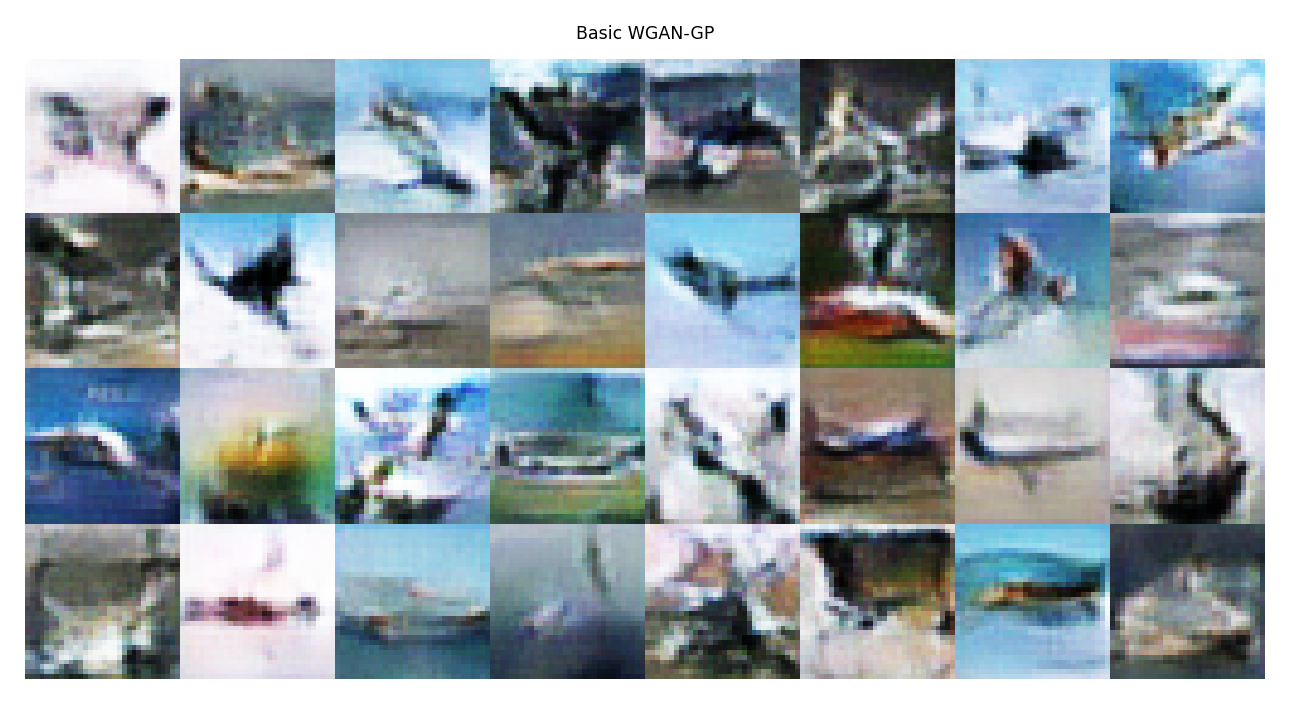

In [11]:
# display a grid of generated images

# Generate images
random_noise = tf.random.normal([num_examples_to_generate, latent_dim])
random_labels = tf.random.uniform(shape=(num_examples_to_generate, 1), minval=0, maxval=num_classes, dtype=tf.int32)

# reduce the variance of the noise
# random_noise = random_noise * 0.5

generated_images = generator([random_noise, random_labels], training=False)

# use make_grid to display the images
grid = make_grid(generated_images.numpy())

plot_grid(grid, 'Basic WGAN-GP')

NameError: name 'img_list' is not defined

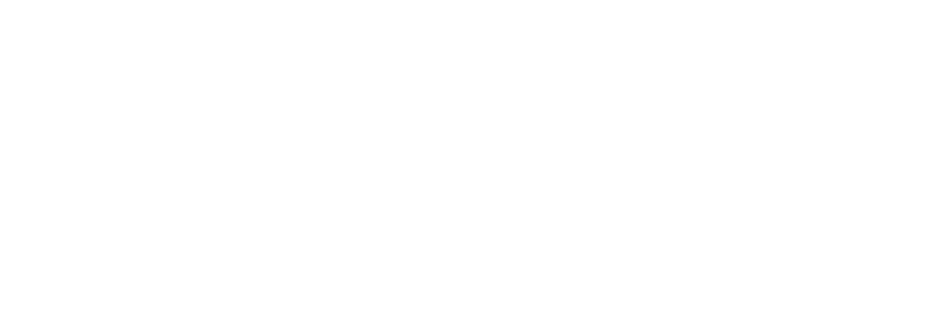

In [12]:
fig = plt.figure(figsize=(12,4))
plt.axis("off")  
pls = [[plt.imshow(im, animated=True)] for im in img_list]

# allow the animation to be any size with animation.embed_limit
plt.rcParams['animation.embed_limit'] = 2**128

ani = animation.ArtistAnimation(fig, pls, interval=500, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

In [ ]:
# generator.save('generator_model_3.h5')
# discriminator.save('discriminator_model_3.h5')

In [ ]:
import tensorflow_addons as tfa

def make_discriminator_model_spec_norm():
    image_input = layers.Input(shape=(size, size, channels))
    label_input = layers.Input(shape=(1,), dtype='int32')
    
    # Embed the label input and reshape it
    label_embedding = layers.Embedding(num_classes, size * size)(label_input)
    label_embedding = layers.Reshape((size, size, 1))(label_embedding)
    
    # Concatenate the image input and label embedding along the channel axis
    combined_input = layers.Concatenate(axis=-1)([image_input, label_embedding])
    
    x = tfa.layers.SpectralNormalization(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))(combined_input)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = tfa.layers.SpectralNormalization(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(1)(x)
    
    model = tf.keras.Model(inputs=[image_input, label_input], outputs=x)
    
    return model

In [ ]:
# create a new generator and discriminator
generator = make_generator_model()
discriminator = make_discriminator_model_spec_norm()

# define the loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# define the optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
# Need to recompile the model to use the new stuff

@tf.function # commenting this as there is some problem with non-eager...
def train_step_spec_norm(images, labels):


    # Train the discriminator first. The original paper recommends training
    # the discriminator for `x` more steps (typically 5) as compared to
    # one step of the generator. Here we will train it for 3 extra steps
    # as compared to 5 to reduce the training time.
    batch_size = tf.shape(images)[0]

    for i in range(5):

        # Get the latent vector
        noise = tf.random.normal([batch_size, latent_dim])
        generated_labels = tf.random.uniform([batch_size, 1], minval=0, maxval=num_classes, dtype=tf.int32)

        with tf.GradientTape() as disc_tape:

            # Generate fake images from the latent vector
            generated_images = generator([noise, generated_labels], training=True)

            # also get interpolations for the gradient penalty
            alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
            diff = generated_images - images
            interpolated = images + alpha * diff

            # Get the logits for the fake images
            fake_output = discriminator([generated_images, generated_labels], training=True)

            # Get the logits for the real images
            real_output = discriminator([images, labels], training=True)

            # Calculate the discriminator loss using the fake and real image logits
            disc_loss = discriminator_loss(real_output,fake_output)

        # Get the gradients w.r.t the discriminator loss
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        # Update the weights of the discriminator using the discriminator optimizer
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))



    # Train the generator
    # Get the latent vector
    noise = tf.random.normal([batch_size, latent_dim])
    labels = tf.random.uniform(shape=(batch_size, 1), minval=0, maxval=num_classes, dtype=tf.int32)
    with tf.GradientTape() as gen_tape:
        # Generate fake images using the generator
        generated_images = generator([noise, labels], training=True)
        # Get the discriminator logits for fake images
        fake_output = discriminator([generated_images, labels], training=True)

        # Calculate the generator loss
        gen_loss = generator_loss(fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

In [ ]:
LOAD_SPEC_NORM_MODEL = False

if LOAD_SPEC_NORM_MODEL:
    # Load discriminator_model_2.h5
    discriminator.load_weights('discriminator_model_spec_norm.h5')
    # Load generator_model_2.h5
    generator.load_weights('generator_model_spec_norm.h5')

else:
    EPOCHS = 100

    for epoch in range(EPOCHS):
        start = time.time()
        
        print(f'Epoch {epoch+1}/{EPOCHS}')
        progbar = Progbar(target=len(train_dataset), width=30, verbose=1, interval=0.05)

        for batch_idx, (image_batch, label_batch) in enumerate(train_dataset):
            train_step_spec_norm(image_batch, label_batch)
            progbar.update(batch_idx + 1)

        # Save the model every 5 epochs
        # if (epoch + 1) % 5 == 0:
            
            # checkpoint.save(file_prefix=checkpoint_dir + 'c-wgan_tf')
            # Produce images for animation
            # tmp = checkpoint_images(generator, [test_latent_dims, test_labels], 'c-wgan_tf')
            # img_list.append(tmp)

        print('Time for epoch {} is {:.2f} sec'.format(epoch + 1, time.time() - start))

In [ ]:
# display a grid of generated images

# Generate images
random_noise = tf.random.normal([num_examples_to_generate, latent_dim])
random_labels = tf.random.uniform(shape=(num_examples_to_generate, 1), minval=0, maxval=num_classes, dtype=tf.int32)

# reduce the variance of the noise
# random_noise = random_noise * 0.5

generated_images = generator([random_noise, random_labels], training=False)

# use make_grid to display the images
grid = make_grid(generated_images.numpy())

plot_grid(grid, 'WGAN-GP with Spectral Normalization')